###**CSCE 5063-001: Assignment 3 - Neural Networks**




            Quan Mai - 010946565

## 1. Implementation MNIST dataset classification using MLP

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [66]:
drive.mount('/content/drive')
X = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/X.csv', header=None).to_numpy()
Y = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/Y.csv', header=None).to_numpy()
W1 = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/initial_W1.csv', header=None).to_numpy()
W2 = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/initial_W2.csv', header=None).to_numpy()
W3 = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/W1.csv', header=None).to_numpy()
W4 = pd.read_csv('/content/drive/My Drive/UoA/ML/lab3/data/W2.csv', header=None).to_numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
L1, L2 = W1.shape[0], W2.shape[0]
la = 3
lr = 0.2

In [68]:
def one_hot_encode(Y):
  one_to_ten = (np.arange(10) + 1)
  Y_hot_encode = 1*(Y == one_to_ten)
  return Y_hot_encode

In [69]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoidDerivative(x):
  return sigmoid(x)*(1-sigmoid(x))

In [70]:
# Forward propagation
def feedForward(X, W1, W2, act):
  """
  return: 
    Y_pred: m x 1
    Z1    : m x L1
    H     : m x L1+1    
  """
  X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
  Z1 = X@W1.T
  H = act(Z1)

  H = np.concatenate([np.ones((H.shape[0], 1)), H], axis=1)
  Y_pred = act(H@W2.T)
  return Y_pred, Z1, H, X

In [71]:
# Cost function
def loss(X, Y, W1, W2, la, act):
  m, n = X.shape[0], X.shape[1]
  Y_pred, _, _, _ = feedForward(X, W1, W2, act)
  weight_1 = np.sum(W1[:, 1:] * W1[:, 1:]) 
  weight_2 = np.sum(W2[:, 1:] * W2[:, 1:])
  cost = 1/m * np.sum(-Y*np.log(Y_pred)-(1-Y)*np.log(1-Y_pred)) + la/(2*m)*(weight_1+weight_2)
  return cost.item()

In [72]:
def backPropagation(X, Y, W1, W2, la, act):
  m, n =  X.shape[0], X.shape[1]
  W1_new, W2_new = W1, W2
  W1_new[:, 0] = W2_new[:, 0] = 0

  Y_pred, Z1, H, X1 = feedForward(X, W1, W2, act) # H(m, L1+1)
  Delta_W1 = np.zeros(W1.shape)
  Delta_W2 = np.zeros(W2.shape)
  
  Beta_2 = Y_pred - Y # m x 10
  Delta_W2 = np.matmul(Beta_2.T, H) #(10,26)
  
  Beta_1 = np.matmul(Beta_2, W2[:, 1:]) * sigmoidDerivative(Z1) # (m,25)
  Delta_W1 = np.matmul(Beta_1.T, X1) # (25,401)

  W1_grad = (Delta_W1 + la * W1_new)/m
  W2_grad = (Delta_W2 + la * W2_new)/m

  return W1_grad, W2_grad

In [73]:
loss(X, one_hot_encode(Y), W3, W4, la, sigmoid)

0.576051030352147

In [74]:
def batchGradientDescent(X, Y, W1, W2, la, lr, act=sigmoid):
  costHistory = []
  costHistory.append(loss(X, Y, W1, W2, la, act))
  k=0
  while True:
    W1_grad, W2_grad = backPropagation(X, Y, W1, W2, la, act)
    W1 -= lr * W1_grad
    W2 -= lr * W2_grad
    costHistory.append(loss(X, Y, W1, W2, la, act))
    if k<3:
      pd.DataFrame(W1_grad).to_csv("W1_grad_iter" + str(k+1) + ".csv", index=False, index_label=False, header=None)
      pd.DataFrame(W2_grad).to_csv("W2_grad_iter" + str(k+1) + ".csv", index=False, index_label=False, header=None)
    k += 1
    if k==500:
      break
  return costHistory, W1, W2

## 2. Plot of loss function J vs. the number of iterations.

In [75]:
cost, weight_1, weight_2 = batchGradientDescent(X, one_hot_encode(Y), W1, W2, la, lr, sigmoid)

In [76]:
def plotLoss(cost):
  plt.plot(cost, color='red')
  plt.title('Cost vs. Iteration')
  plt.xlabel('iteration')
  plt.ylabel('cost')
  plt.show()

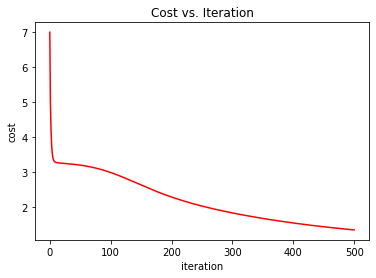

In [77]:
plotLoss(cost)

# 3. Prediction, and Accuracy

In [78]:
def predict(X, W1, W2, act):
  """
    X: input features
    W1, W2: weights after trained
  """
  Y_pred, _, _, _ = feedForward(X, W1, W2, act)
  return np.argmax(Y_pred, axis=1) + 1

In [79]:
def accuracy(X, Y, W1, W2, act):
  """
   This function returns prediction's accuracy after 500 iterations
  """
  Y_pred = predict(X, W1, W2, act).reshape(Y.shape)
  num = (Y_pred-Y == 0).sum()
  return num * 100/X.shape[0]
accuracy(X, Y, weight_1, weight_2, sigmoid)

85.72

In [80]:
def classify_a_list(a_list, X, W1, W2, act):
  """
  a_list: a list of index in dataset that users want to classify
  X     : input features
  W1, W2: trained weights
  act   : activation function
  """
  y_pred = predict(X, weight_1, weight_2, sigmoid)
  result_list = [y_pred[index] for index in a_list]
  return result_list

In [81]:
a_list = np.array([2170, 144, 1581, 2445, 3392, 814, 1377, 528, 3944, 4627])
print(classify_a_list(a_list, X, weight_1, weight_2, sigmoid))

[4, 10, 3, 4, 6, 1, 2, 1, 7, 3]


The network classifies incorrectly for example indexed 4828, which should be predicted 9.